In [1]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import re
import spacy
import os
from dotenv import load_dotenv
from tqdm import tqdm
import numpy as np

from mongo_wrapper.mongo_wrapper import MongoWrapper


load_dotenv()
MONGO_IP = os.getenv("MONGO_IP")
MONGO_PORT = os.getenv("MONGO_PORT")
MONGO_DB = os.getenv("MONGO_DB")
MONGO_USERNAME = os.getenv("MONGO_USERNAME")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")

# states to categorize 
STATES = [
    "Guanajuato",
    "Michoacán",
    "Sinaloa",
    "Chihuahua",
    "Guerrero",
    "Tamaulipas",
    "Baja California",
    "Zacatecas",
    "Colima",
    "Jalisco"]

# dimensions of poverty
POVERTY_DIMENSIONS = {
    "INCOME": [
        "desempleo", "sueldo mínimo", "salario bajo", "inflación", "deudas",
        "crisis", "préstamos", "despidos", "recortes", "quiebra", "pobreza",
        "falta de chamba", "pérdida de empleo", "no hay trabajo", "sin chamba",
        "unemployment", "low wages", "bankrupt", "jobless", "struggling",
        "salario miserable", "jodido", "quedarse sin trabajo",
        "inestabilidad económica", "dificultades financieras", "falta de recursos",
        "sin ingresos suficientes", "incertidumbre laboral", "situación precaria",
        "bajos ingresos", "falta de oportunidades", "dificultad para ahorrar",
        "necesidades básicas insatisfechas", "problemas económicos", "vivir al día",
        "inseguridad laboral", "trabajos temporales", "sin ingreso fijo", 
        "economía familiar reducida", "salario insuficiente", "búsqueda de empleo",
        "sin un peso", "estar en la ruina", "no me alcanza",
        "estar quebrado", "ganar una miseria", "no hay chamba",
        "sueldo de hambre", "vivir con lo que cae", "quedé sin trabajo",
        "buscando trabajo"],
    "ACCESS TO HEALTH SERVICES": [
        "sin medicinas", "hospital lejano", "esperas", "sin seguro", "mala atención",
        "enfermedad", "rechazado", "sin tratamiento", "medicinas caras", "sin doctores",
        "no hay medicinas", "no hay doctores", "centro de salud cerrado", "hospital saturado",
        "no hay atención médica", "healthcare crisis", "expensive medicine", "medical neglect",
        "mal servicio médico", "broncas de salud", "te dejan morir",
        "deficiencia en el sistema de salud", "falta de personal médico", 
        "servicios médicos inaccesibles", "centros médicos distantes", 
        "tratamientos costosos", "falta de atención preventiva", 
        "servicios de urgencias insuficientes", "espera excesiva para atención",
        "falta de especialistas", "medicamentos inaccesibles", "atención médica deficiente",
        "personas sin cobertura médica", "salud pública colapsada", "sistemas de salud precarios",
        "personal médico insuficiente", "instalaciones sanitarias inadecuadas",
        "horas esperando", "no hay ni aspirinas", "no hay ni paracetamol", 
        "hospitales lejanos", "pura negligencia", "no hay citas",
        "citas médicas muy tardías", "salud pública deficiente",  
        "automedicación", "no hay médicos especialistas"],
    "EDUCATIONAL LAG": [
        "sin escuela", "analfabetismo", "deserción", "acceso a la educación",
        "calidad educativa", "recursos didácticos", "infraestructura escolar",
        "escuela lejana", "escuela lejos", "sin útiles", "ausentismo",
        "sin maestros", "rezago escolar", "niños sin clases", "poca educación",
        "school dropout", "no teachers", "poor education", "no school supplies",
        "ni estudian ni trabajan", "escuela en ruinas",
        "falta de acceso a educación", "baja tasa de escolaridad", "educación de baja calidad",
        "jóvenes sin preparación", "falta de oportunidades educativas", "formación académica limitada",
        "problemas de aprendizaje", "abandono escolar temprano", "educación incompleta",
        "infraestructura educativa deficiente", "falta de material didáctico", 
        "educación discontinua", "escuelas en mal estado", "escolaridad interrumpida",
        "recursos pedagógicos insuficientes", "desigualdad educativa",
        "no hay profes", "maestros fantasma", "se caen los techos", 
        "escuelas sin recursos", "no hay clases", "jóvenes sin estudiar", 
        "escuelas en mal estado", "faltan materiales escolares",
        "escuelas sin agua", "difícil acceso a la escuela"],
    "ACCESS TO SOCIAL SECURITY": [
        "sin contrato", "economía informal", "informal", "sin pensión",
        "sin derechos", "explotación", "sin ahorro", "sin prestaciones",
        "desprotección", "trabajo ilegal", "sin seguro", "sin IMSS",
        "chamba sin contrato", "trabajo mal pagado", "explotado", 
        "no benefits", "no retirement", "informal jobs", "unprotected workers",
        "sin aguinaldo", "trabajo en negro",
        "empleo sin protección social", "falta de seguridad laboral", "sin beneficios laborales",
        "carencia de servicios sociales", "trabajadores desprotegidos", "jubilación insuficiente",
        "falta de apoyo institucional", "vulnerabilidad social", "falta de cobertura social",
        "desprotección laboral", "servicios sociales inaccesibles", "sin acceso a ayudas sociales",
        "empleo precario", "trabajadores marginados", "condiciones laborales precarias",
        "empleos de subsistencia", "sin acceso a beneficios sociales",
        "sin papeles", "trabajo por fuera", "trabajo no registrado", 
        "te dan de alta con menos", "trabajo informal", "sin jubilación",
        "condiciones abusivas", "sin beneficios laborales", "sin finiquito",
        "sin protección laboral"],
    "HOUSING": [
        "sin agua", "sin luz", "hacinamiento", "desalojo", "vivienda precaria",
        "sin techo", "goteras", "renta cara", "casa insegura", "sin baño",
        "techos de lámina", "cuartos de cartón", "casas abandonadas", "inundaciones",
        "bad housing", "slum", "no electricity", "unsafe home", "eviction notice",
        "vivir entre ratas", "se les cae la casa",
        "vivienda inadecuada", "condiciones habitacionales deficientes", "falta de servicios básicos",
        "asentamientos irregulares", "déficit habitacional", "falta de acceso a vivienda digna",
        "viviendas en zonas de riesgo", "condiciones insalubres", "viviendas sin servicios esenciales",
        "problemas de habitabilidad", "viviendas improvisadas", "hogares sin infraestructura básica",
        "viviendas en mal estado", "construcciones vulnerables", "viviendas en zonas marginales",
        "imposibilidad de acceder a vivienda", "viviendas no seguras",
        "casa de lámina", "viviendo en la calle", "casas de cartón", "barrio marginal",
        "casa sin drenaje", "colonia sin pavimentar", "renta muy cara",
        "sin agua potable", "se mete el agua cuando llueve", "apagones frecuentes",
        "casa sin ventilación", "techo que gotea"],
    "ACCESS TO FOOD": [
        "hambre", "desnutrición", "comida escasa", "sin alimentos", "comida cara",
        "ayuda alimentaria", "escasez", "comida mala", "dieta pobre", "inseguridad alimentaria",
        "no hay comida", "ni pa' frijoles", "colas para comida", "falta de comida",
        "food insecurity", "starving", "malnutrition", "no food on table",
        "tragando aire", "comer una vez al día",
        "alimentación insuficiente", "nutrición inadecuada", "falta de acceso a alimentos",
        "déficit nutricional", "alimentos de mala calidad", "dieta insuficiente",
        "carencia alimentaria", "pobreza alimentaria", "falta de variedad en la dieta",
        "aumento de precios alimentarios", "falta de alimentos básicos", "crisis alimentaria",
        "problemas de desnutrición", "hambruna", "dependencia de asistencia alimentaria",
        "alimentos inaccesibles", "problemas de alimentación",
        "morirse de hambre", "ni tortillas hay", "comer cada tercer día",
        "no alcanza para comida", "niños con hambre", "sin comida suficiente",
        "no hay ni para huevos", "a puro arroz", "comiendo solo una vez al día",
        "todo muy caro", "precios imposibles"],
    "SOCIAL COHESION": [
        "fragmentación", "polarización", "exclusión", "discriminación", "conflicto",
        "desconfianza", "marginalización", "tensiones", "estigmatización",
        "racismo", "odio de clase", "no hay comunidad", "violencia entre vecinos",
        "division social", "hate speech", "segregation", "marginalized", "resentimiento social",
        "pandillas", "se odian entre barrios",
        "falta de integración social", "ruptura del tejido social", "división comunitaria",
        "falta de solidaridad", "problemas de convivencia", "falta de inclusión",
        "desigualdad social", "sectores sociales aislados", "segregación urbana",
        "comunidades divididas", "aislamiento social", "falta de pertenencia",
        "grupos sociales antagónicos", "conflictos comunitarios", "desintegración social",
        "falta de cohesión", "degradación de relaciones sociales", "fracturas sociales",
        "nadie se habla", "comunidades divididas", "no confiar en nadie", 
        "barrios enemistados", "zonas peligrosas", "sociedades cerradas",
        "discriminación por origen", "separación entre ricos y pobres",
        "barrios conflictivos", "falta de unión", "intolerancia social"]}


# channels to search for 
CHANNELS = [
    "ElUniversalOnline", 
    "ElPaísMéxico", 
    "RevistaProceso", 
    "PolíticoMX", 
    "LaJornada", 
    "LaRazóndeMéxico", 
    "SinEmbargo.mx"]

def main():
    mongo_client = MongoWrapper(
        db=MONGO_DB,
        user=MONGO_USERNAME,
        password=MONGO_PASSWORD,
        ip=MONGO_IP,
        port=MONGO_PORT)
    
    # verify available channels 
    available_channels = mongo_client.get_all_collections()
    print(f'available channels : {available_channels}')
    
    # filter for channels of interest 
    channels_to_analyze = [ch for ch in CHANNELS if ch in available_channels]
    print(f'channels to analyze: {channels_to_analyze}')
    
    # dictionary for results
    results = {
        "state": [],
        "dimension": [],
        "keyword": [],
        "count": []}
    
    state_dimension_counts = {state: {dim: {} for dim in POVERTY_DIMENSIONS} for state in STATES}
    
    for channel in channels_to_analyze:
        print(f"\nanalyzing: {channel}")
        
        # get posts for that channel
        posts = mongo_client.get_collection_entries(collection=channel)
        for post in posts:
            post.pop("comments", None)
        
        df = pd.DataFrame(posts)
        
        if df.empty or 'message' not in df.columns or 'posting_ts' not in df.columns:
            print(f"  skipping channel {channel}")
            continue
        
        df['posting_datetime'] = pd.to_datetime(df['posting_ts'], unit='s')
        
        df_2022 = df[(df['posting_datetime'] >= '2022-01-01') & 
                     (df['posting_datetime'] <= '2022-12-31')]
        
        print(f"  posts found for 2022: {len(df_2022)}")
        
        if df_2022.empty:
            print(f"  no posts for channel {channel} in 2022. skipping.")
            continue
        
        for _, post in tqdm(df_2022.iterrows(), total=len(df_2022), desc=f"analyzing posts for channel {channel}"):
            message = post['message'].lower() if isinstance(post['message'], str) else ""
            
            # check if the post mentions any of the states
            mentioned_states = []
            for state in STATES:
                if state.lower() in message:
                    mentioned_states.append(state)
            
            # if not, skip to following post
            if not mentioned_states:
                continue
            
            # count occurrences of keywords in the message
            for state in mentioned_states:
                for dimension, keywords in POVERTY_DIMENSIONS.items():
                    for keyword in keywords:
                        pattern = r'\b' + re.escape(keyword.lower()) + r'\b'
                        count = len(re.findall(pattern, message))
                        
                        if count > 0:
                            if keyword in state_dimension_counts[state][dimension]:
                                state_dimension_counts[state][dimension][keyword] += count
                            else:
                                state_dimension_counts[state][dimension][keyword] = count
    
    for state in STATES:
        for dimension, keywords_dict in state_dimension_counts[state].items():
            for keyword, count in keywords_dict.items():
                results["state"].append(state)
                results["dimension"].append(dimension)
                results["keyword"].append(keyword)
                results["count"].append(count)
    
    # df for results 
    results_df = pd.DataFrame(results)
    
    os.makedirs("telegram_results", exist_ok=True)
    results_df.to_csv("telegram_results/telegram_keyword_counts_2022.csv", index=False)
    print("\nresults saved in 'telegram_results/telegram_keyword_counts_2022.csv'")

if __name__ == "__main__":
    main()

2025-04-30 12:28:28,752 WARNING Logger Mongo was configured with True console stream
2025-04-30 12:28:29,067 INFO Connected to thesis database on 206.81.16.39


available channels : ['Michoacán empleo', 'Colima servicios básicos', 'Baja California hambre', 'Colima pobreza', 'Tamaulipas alimentación', 'Sinaloa sociedad', 'Guerrero médico', 'Sinaloa integración', 'Guerrero crisis', 'Guanajuato médico', 'Zacatecas economía', 'Guanajuato seguro social', 'Guanajuato inseguridad', 'Guerrero economía', 'Guanajuato desarrollo', 'Colima habitaciónes', 'Michoacán atención médica', 'Guanajuato comunidad', 'Chihuahua alimentos', 'Jalisco habitaciónes', 'Sinaloa habitaciónes', 'Zacatecas salud', 'Tamaulipas hospital', 'Switzerland living', 'Chihuahua seguro social', 'Michoacán', 'Michoacán universidad', 'Switzerland food', 'Chihuahua seguridad social', 'Guanajuato aprendizaje', 'Sinaloa crisis', 'Guanajuato pensión', 'Tamaulipas salud', 'Chihuahua integración', 'Baja California comunidad', 'Guanajuato condiciones', 'Switzerland employment', 'Tamaulipas vivienda', 'Chihuahua salud', 'Baja California', 'Zacatecas', 'Michoacán beneficios', 'Sinaloa desempleo'

In [ ]:
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from collections import Counter
import re
import spacy

from mongo_wrapper.mongo_wrapper import MongoWrapper

import os
from dotenv import load_dotenv

MONGO_IP = os.getenv("MONGO_IP")
MONGO_PORT = os.getenv("MONGO_PORT")
MONGO_DB = os.getenv("MONGO_DB")
MONGO_USERNAME = os.getenv("MONGO_USERNAME")
MONGO_PASSWORD = os.getenv("MONGO_PASSWORD")

mongo_client = MongoWrapper(
    db=MONGO_DB,
    user=MONGO_USERNAME,
    password=MONGO_PASSWORD,
    ip=MONGO_IP,
    port=MONGO_PORT
)

channels = mongo_client.get_all_collections()
print(f'All channels: {channels}')

channel_posts = {}
for channel in channels:
    posts = mongo_client.get_collection_entries(collection=channel)
    for post in posts:
        post.pop("comments", None)

    channel_posts[channel] = pd.DataFrame(posts)


data = channel_posts["ElUniversalOnline"]

data['posting_datetime'] = pd.to_datetime(data['posting_ts'], unit='s')
data = data.sort_values('posting_datetime')
data.set_index('posting_datetime', inplace=True)

nlp = spacy.load("es_core_news_sm")

keywords = [
"sin escuela",
"analfabetismo",
"deserción",
"Acceso a la educación",
"Calidad educativa",
"Recursos didácticos",
"Infraestructura escolar",
"escuela lejana",
"escuela lejos",
"sin útiles",
"ausentismo",
"sin maestros",
"rezago escolar"]

In [ ]:
keywords_lemmas = set()
for kw in keywords:
    doc = nlp(kw)
    filtered_lemmas = {token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha}
    keywords_lemmas.update(filtered_lemmas)

print("Lemmatized: ", keywords_lemmas)


Lemmatized:  {'recurso', 'acceso', 'lejano', 'analfabetismo', 'didáctico', 'escolar', 'rezago', 'deserción', 'escuela', 'educación', 'lejos', 'útil', 'calidad', 'infraestructura', 'educativo', 'ausentismo', 'maestro'}


In [ ]:
def contains_crime(text: str):
    text_lower = text.lower()
    return any(kw in text_lower for kw in keywords)

In [ ]:
def contains_keyword_lemmatized(text: str) -> bool:
    doc = nlp(text)
    return any(token.lemma_.lower() in keywords_lemmas for token in doc)

In [ ]:
data['contains_keyword'] = data['text'].apply(contains_keyword_lemmatized)

df_daily_total = data.resample('D').count()['_id']
df_daily_keyword = data.resample('D')['contains_keyword'].sum()
df_daily_not_keyword = df_daily_total - df_daily_keyword

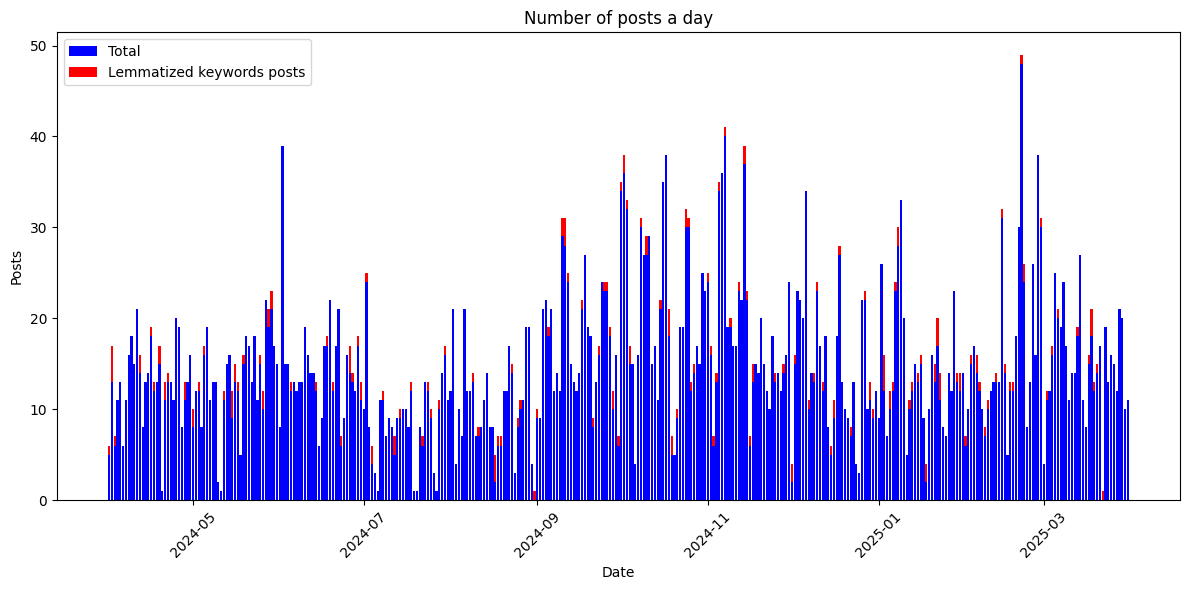

Criminal topics publiscations ratio: 196 out of 5523 (3.55%)


In [ ]:
plt.figure(figsize=(12,6))
plt.bar(df_daily_total.index, df_daily_not_keyword, label='Total', color='blue')
plt.bar(df_daily_total.index, df_daily_keyword, bottom=df_daily_not_keyword, label='Lemmatized keywords posts', color='red')
plt.title("Number of posts a day")
plt.xlabel("Date")
plt.ylabel("Posts")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

keyword_count = data['contains_keyword'].sum()
total_posts = len(data)
print(f"Criminal topics publiscations ratio: {keyword_count} out of {total_posts} ({keyword_count/total_posts:.2%})")

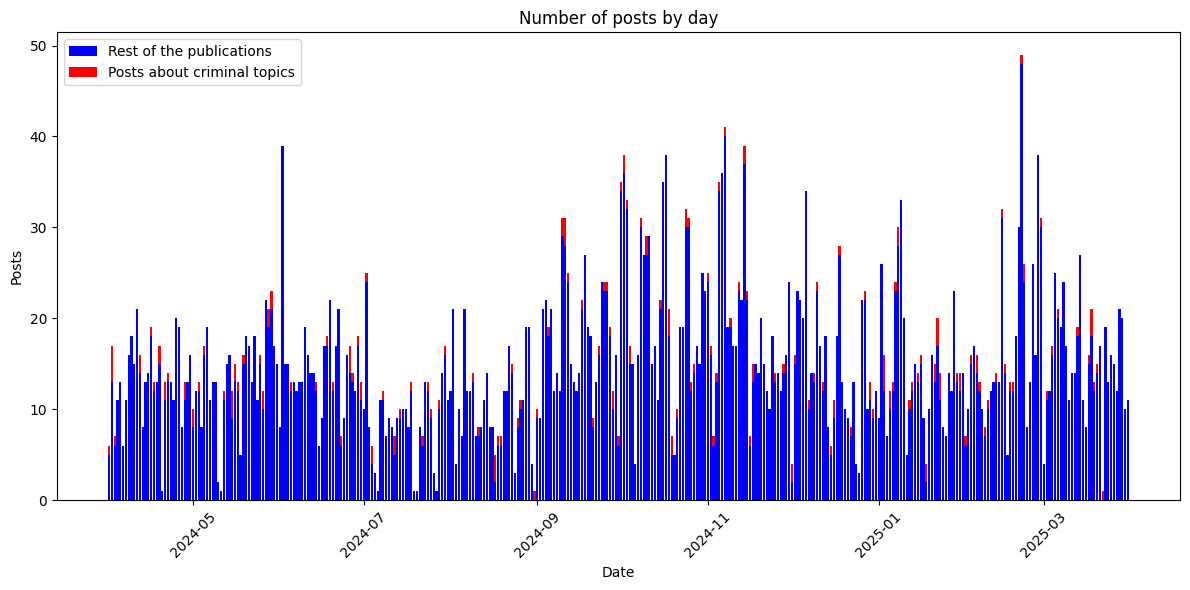

In [ ]:
data['is_crime'] = data['text'].apply(contains_keyword_lemmatized)

df_daily_total = data.resample('D').count()['_id']

df_daily_crime = data.resample('D')['is_crime'].sum()

df_daily_not_crime = df_daily_total - df_daily_crime

plt.figure(figsize=(12,6))
plt.bar(df_daily_total.index, df_daily_not_crime, label='Rest of the publications', color='blue')
plt.bar(df_daily_total.index, df_daily_crime, bottom=df_daily_not_crime, label='Posts about criminal topics', color='red')
plt.title("Number of posts by day")
plt.xlabel("Date")
plt.ylabel("Posts")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
data['is_crime'] = data['text'].apply(contains_keyword_lemmatized)

crime_count = data['is_crime'].sum()
total_posts = len(data)
print(f"Criminal topics publiscations ratio: {crime_count} out of {total_posts} ({crime_count/total_posts:.2%})")

Criminal topics publiscations ratio: 196 out of 5523 (3.55%)


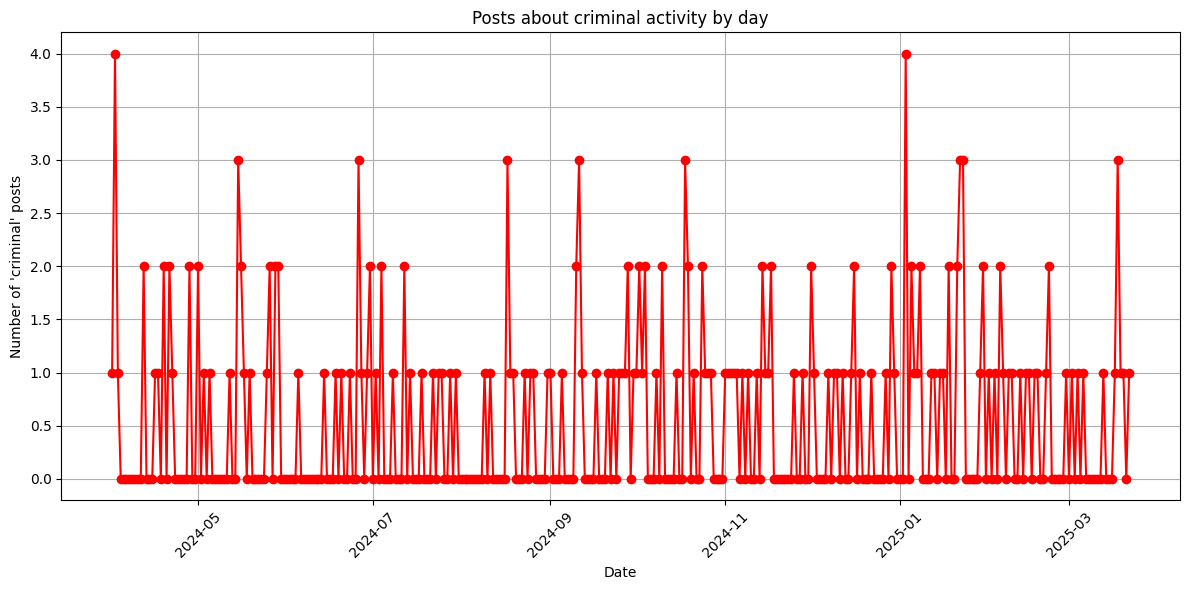

In [ ]:
df_crime = data[data['is_crime']]
df_crime_daily = df_crime.resample('D').count()
plt.figure(figsize=(12,6))
plt.plot(df_crime_daily.index, df_crime_daily['_id'], marker='o', linestyle='-', color='red')
plt.title("Posts about criminal activity by day")
plt.xlabel("Date")
plt.ylabel("Number of 'criminal' posts")
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid()
plt.show()

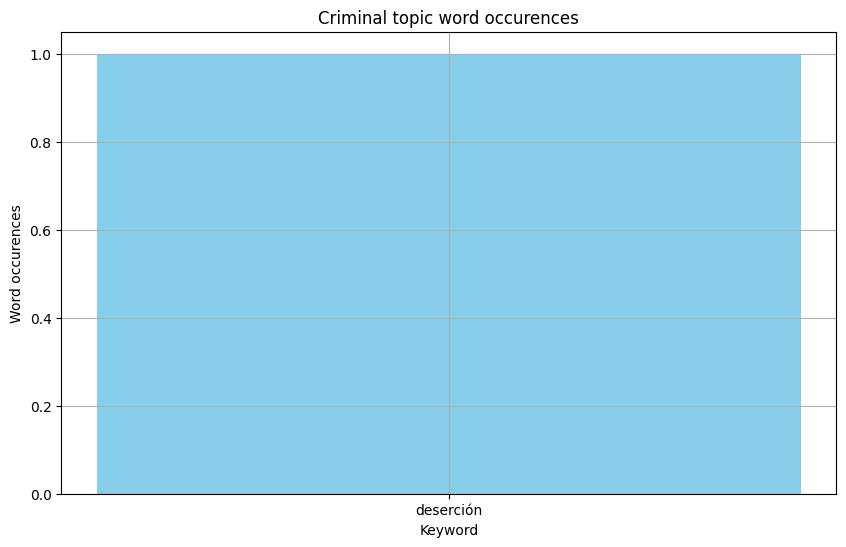

In [ ]:
all_keywords = []
for text in data['text']:
    text_lower = text.lower()
    for kw in keywords:
        matches = re.findall(kw, text_lower)
        if matches:
            all_keywords.extend([kw] * len(matches))

keyword_counts = Counter(all_keywords)

plt.figure(figsize=(10,6))
plt.bar(keyword_counts.keys(), keyword_counts.values(), color="skyblue")
plt.title("Criminal topic word occurences")
plt.xlabel("Keyword")
plt.ylabel("Word occurences")
plt.grid(True)
plt.show()